# Ice Out Predictor for Rainy Lake

Ice out is a key date in the annual life of the lake. For the tourism industry, ice out is when the lake becomes generally available for fishing and recreation. For many species native to the lake, ice out marks a transition from Winter to Summer patterns of life. In typical years, by the time of ice out the Spring water flows have already increased significantly due to the Spring runoff, with increased summer rains not far behind.

![Rainy Lake Ice Out](../images/DSCN0059_.jpg)

Ice out on Rainy Lake is the first day in the year in which a boat can travel from Island View to Kettle Falls unimpeded by ice.  This has been recorded by the International Falls Daily Journal since 1930.

The purpose of this notebook is to investigate the historical data for ice out on Rainy Lake with a view to determining its role in the management of the lake and surrounding watershed.

* <a href='#section01'>Initialization</a>
* <a href='#section02'>Distribution of Ice Out Dates</a>
* <a href='#seciont03'>Fitting Ice Out Dates to a Trendline</a>

<a id='section01'></a>
## Initialization

In [1]:
# Display graphics inline with the notebook
%matplotlib inline

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import os
import datetime
import scipy.stats as stats
import pickle

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display

# graphics context
sns.set_context("poster")

## Ice Out Descriptive Statistics

Records for ice out dates on Rainy Lake from 1930 to the present day are maintained by the Minnesota DNR, available [here](http://www.dnr.state.mn.us/ice_out/index.html). The data set has been previously downloaded into a file in the data directory. The ice out dates are converted to an integer 'day of year' and stored as a Pandas series object.

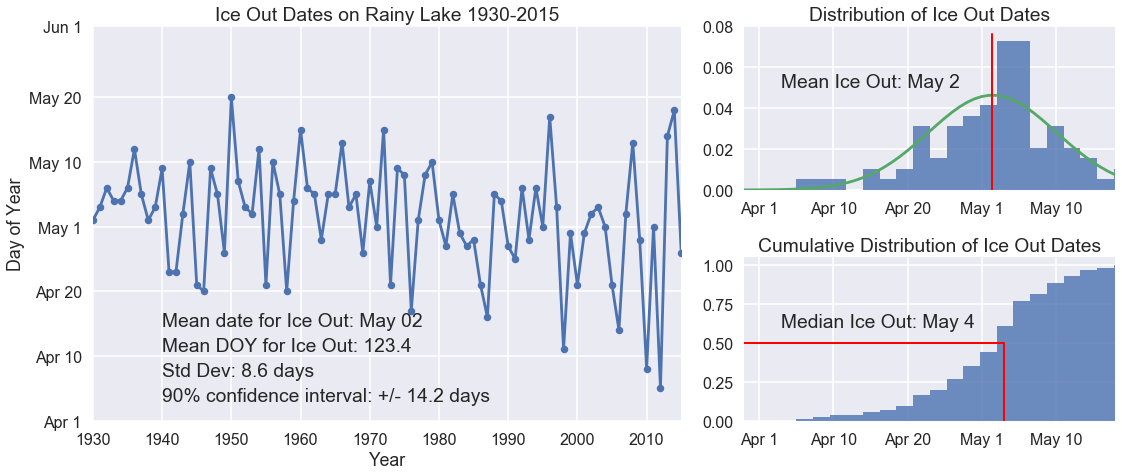

In [2]:
# read .csv file
RL_ICEOUT = pd.read_csv('../data/IceOut_RL.txt',index_col=0,parse_dates=True,skiprows=1)

# remove duplicated data
RL_ICEOUT = RL_ICEOUT[RL_ICEOUT[' source']=='MNDNR-SCO']

# drop unneeded columns
RL_ICEOUT.drop(' source', axis=1, inplace=True)
RL_ICEOUT.drop(' comments', axis=1, inplace=True)

# translate to a pd Series with 'day of year' of ice out events
IO_DOY = pd.Series(RL_ICEOUT.index.dayofyear, index=RL_ICEOUT.index.year)

# fit normal distribution
param = stats.norm.fit(np.array(IO_DOY))

# visualization
plt.figure(figsize=(16,7))

# plot of PDF and overlay Normal Distribution fit
plt.subplot2grid((2,5),(0,3),colspan=2)
x = np.linspace(90,150,61)
pdf = stats.norm.pdf(x,loc=param[0],scale=param[1])
plt.hist(np.array(IO_DOY),normed=1,alpha=0.8,bins=20)
plt.plot(x,pdf)
plt.title('Distribution of Ice Out Dates')
plt.xticks([92,102,112,122,132,142,153],
           ['Apr 1','Apr 10','Apr 20','May 1','May 10','May 20','Jun 1'])
plt.plot([param[0],param[0]],plt.ylim(),'r',lw=2)
plt.annotate('Mean Ice Out: May 2',xy=(95,0.05))
plt.xlim(90,140)

# plot cumulative PDF
plt.subplot2grid((2,5),(1,3),colspan=2)
IO_DOY.hist(cumulative=True,alpha=0.8,bins=20,normed=True)
plt.title('Cumulative Distribution of Ice Out Dates')
plt.xticks([92,102,112,122,132,142,153],
           ['Apr 1','Apr 10','Apr 20','May 1','May 10','May 20','Jun 1'])
plt.plot([90,IO_DOY.median(),IO_DOY.median()],[0.5,0.5,0],'r',lw=2)
plt.annotate('Median Ice Out: May 4',xy=(95,0.6))
plt.xlim(90,140)

# create time series plot
ax = plt.subplot2grid((2,5),(0,0),rowspan=2,colspan=3)
IO_DOY.plot(marker='.',ms=15)
plt.yticks([92,102,112,122,132,142,153],
           ['Apr 1','Apr 10','Apr 20','May 1','May 10','May 20','Jun 1'])
plt.xlabel('Year')
plt.ylabel('Day of Year')
plt.title('Ice Out Dates on Rainy Lake 1930-2015')

idate = datetime.datetime(2016,1,1) + datetime.timedelta(days=param[0]-1)
s = idate.strftime('Mean date for Ice Out: %b %d \n')
s += 'Mean DOY for Ice Out: {0:.1f}\n'.format(param[0])
s += 'Std Dev: {0:.1f} days \n'.format(param[1])
s += '90% confidence interval: +/- {0:.1f} days'.format(1.645*param[1])

plt.annotate(s,(1940,95),linespacing=1.5)

plt.tight_layout()

fname = '../images/IceOutData.png'
plt.savefig(fname)
!convert $fname -trim $fname

## Significance of Ice Out

### Load Data Sources

In [4]:
dir = '../data/'

# Rainy River Flowrate, units of cubic meters per second
RR = pd.read_pickle(dir+'RR.pkl')

# Rainy Lake Level, units of meters
RL = pd.read_pickle(dir+'RL.pkl')

# Stage-Area function for Rainy Lake, units of ?
area = pd.read_pickle(dir+'area.pkl')['Rainy Lake']

# Stage-Volume function for Rainy Lake, units of millions of cubic meters
volume = pd.read_pickle(dir+'volume.pkl')['Rainy Lake']

# Rule Curves for Rainy Lake, units of meters
RL2000 = pd.read_pickle(dir+'RL2000.pkl')
RL1970 = pd.read_pickle(dir+'RL1970.pkl')

# Discharge Relationship (Thompson, 2014), units of meters
data = pd.DataFrame([
    [335.40,    0.0],
    [336.00,  399.0],
    [336.50,  425.0],
    [336.75,  443.0],
    [337.00,  589.0],
    [337.25,  704.0],
    [337.50,  792.0],
    [337.75,  909.0],
    [338.00, 1014.0],
    [338.50, 1156.0],
    [339.00, 1324.0],
    [339.50, 1550.0],
    [340.00, 1778.0]
])

# Create a function to compute maximum discharge as function of lake elevation
from scipy.interpolate import interp1d
Qmax = interp1d(data[0],data[1])

# Compute inflow
Inflow = RR + RL.map(volume).diff()*1000000.0/86400.0

### Historical Lake Inflows

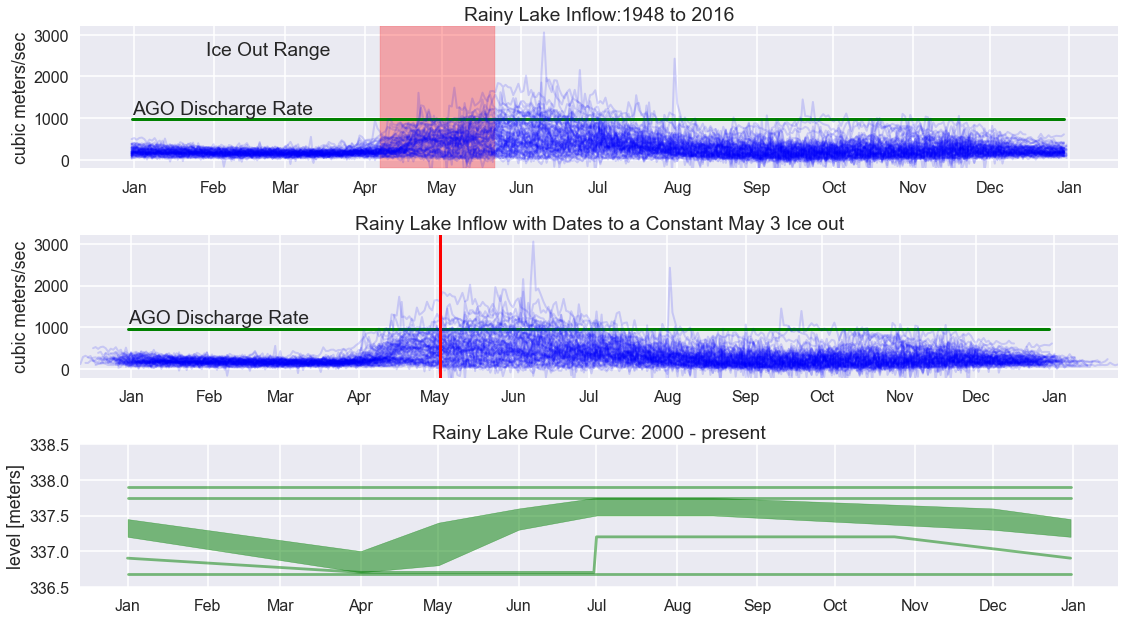

In [10]:
ymin = -200
ymax = 3200
yrA = '1948'
yrB = '2016'

H = RL2000.copy()

dateA = datetime.datetime(2014,1,1)

plt.figure(figsize=(16,9))
plt.subplot(3,1,1)
H['AGO'].map(Qmax).plot(color='g',lw=3)
for (yr,r) in Inflow[yrA:yrB].groupby(Inflow[yrA:yrB].index.year):
    shift = dateA - datetime.datetime(yr,1,1)
    r = r.tshift(shift.days)
    r.plot(color='b',alpha=0.15,lw=2)
    
doyA = plt.xlim()[0] + IO_DOY.min()
doyB = plt.xlim()[0] + IO_DOY.max()

plt.fill_between([doyA,doyB],[ymin,ymin],[ymax,ymax],color='r',alpha=0.3)

plt.ylabel('cubic meters/sec')
plt.title('Rainy Lake Inflow:' + yrA + ' to ' + yrB)
plt.ylim(ymin,ymax);
a,b = plt.xlim()
plt.xlim(a-20,b+20)
plt.annotate('Ice Out Range',xy=(16100,2500))
plt.annotate('AGO Discharge Rate',xy=(16071,1100))

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Adjusted Inflows

plt.subplot(3,1,2)
plt.xlim(a-20,b+20)
H['AGO'].map(Qmax).plot(color='g',lw=3)
for (yr,r) in Inflow[yrA:yrB].groupby(Inflow[yrA:yrB].index.year):
    io_shift = IO_DOY[yr]-123
    shift = dateA - datetime.datetime(yr,1,1)
    r = r.tshift(shift.days - io_shift)
    r.plot(color='b',alpha=0.15,lw=2)
    x = 16071 + IO_DOY[yr] - io_shift
    plt.plot([x,x],[ymin,ymax],'r',alpha=0.5)

plt.title('Rainy Lake Inflow with Dates to a Constant May 3 Ice out')
plt.ylabel('cubic meters/sec')
plt.ylim(ymin,ymax);
#plt.gca().get_xaxis().set_ticklabels([])
plt.annotate('AGO Discharge Rate',xy=(16071,1100))

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Plot 2000 Rule Curves

plt.subplot(3,1,3)

plt.plot(RL2000.index,RL2000['ELW'],color='g',alpha=0.5)
plt.plot(RL2000.index,RL2000['EDL'],color='g',alpha=0.5)
plt.plot(RL2000.index,RL2000['EHW'],color='g',alpha=0.5)
plt.plot(RL2000.index,RL2000['AGO'],color='g',alpha=0.5)

plt.fill_between(RL2000.index,
                 RL2000['LRC'].tolist(),
                 RL2000['URC'].tolist(),
                 color='g', alpha=0.5)
plt.ylim(336.5,338.5)
plt.ylabel('level [meters]')
plt.title('Rainy Lake Rule Curve: 2000 - present')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout();

fname = '../images/IceOutInflows.png'
plt.savefig(fname)
!convert $fname -trim $fname

### Relationship of Ice Out to Summer High Water Events

[22, 22, 23] [2, 6, 11] [34.0, 176.0, 467.0] [120.0, 127.0, 142.0]
17.0
29.3333333333
42.4545454545


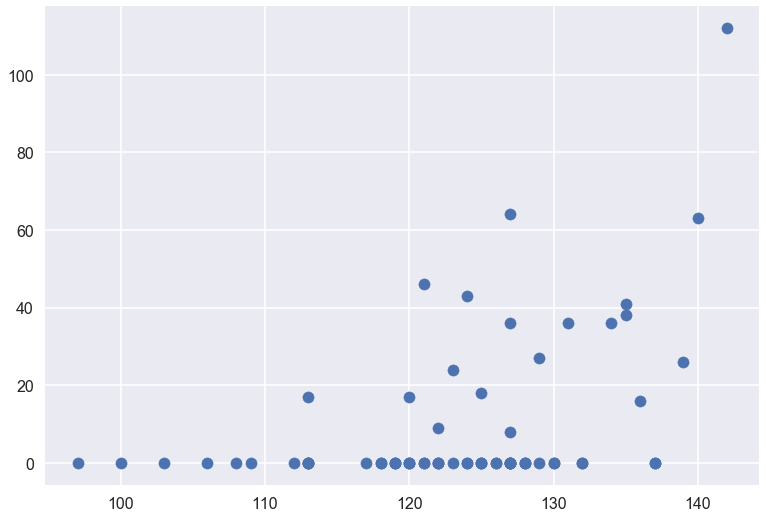

In [13]:
# Are ice-out dates correlated with level and flow data?

# create DataFrame for 'day of year' of ice out events
ds = pd.Series(RL_ICEOUT.index.dayofyear, index=RL_ICEOUT.index.year)
df = pd.DataFrame(ds)
df.columns = ['DOY']

# create DataFrame with Lake Level data
level = pd.DataFrame(RL)
level.columns = ['Level']

# is the lake level greater than EHW and AGO levels
AGO = 337.90
EHW = 337.75
level['EHW'] = level['Level'] > EHW
level['AGO'] = level['Level'] > AGO

# concatenate
df = pd.concat([df,level['AGO'].groupby(level.index.year).sum()],axis=1)
df.columns = ['DOY','AGO']
df['High Water'] = df['AGO'] > 0
df['Early'] = df['DOY'] <= 123.4
df['Late'] = df['DOY'] > 123.4

x = df.ix['1948':]['DOY']
y = df.ix['1948':]['AGO']
plt.scatter(x,y)

# trim to year range
df = df.ix[yrA:yrB]

#print(df.loc[df['Late']].sum())

k = 0
nyr = [0,0,0]
nAGO = [0,0,0]
nDays = [0,0,0]
nDate = [0,0,0]
for idx in df.sort_values('DOY').index:
    k += 1
    if k/len(df) < 0.333:
        nyr[0] += 1
        if df.ix[idx,'High Water']:
            nAGO[0] += 1
            nDays[0] += df.ix[idx,'AGO']
            nDate[0] = df.ix[idx,'DOY']
    elif k/len(df) < 0.666:
        nyr[1] += 1
        if df.ix[idx,'High Water']:
            nAGO[1] += 1    
            nDate[1] = df.ix[idx,'DOY']
            nDays[1] += df.ix[idx,'AGO']    
    else:
        nyr[2] += 1
        if df.ix[idx,'High Water']:
            nAGO[2] += 1 
            nDays[2] += df.ix[idx,'AGO']
            nDate[2] = df.ix[idx,'DOY']
            
print(nyr,nAGO,nDays,nDate)

for k in range(0,3):
    print(nDays[k]/nAGO[k])
            
#df.plot.pie('High Water')
# Fraction of Years with High Water > AGO
#df[['AGO','Early']].plot('Early').pie()

#plt.xticks([92,102,112,122,132,142,153],
#           ['Apr 1','Apr 10','Apr 20','May 1','May 10','May 20','Jun 1']);

## Indicators of Change

### Ice Out Trendline

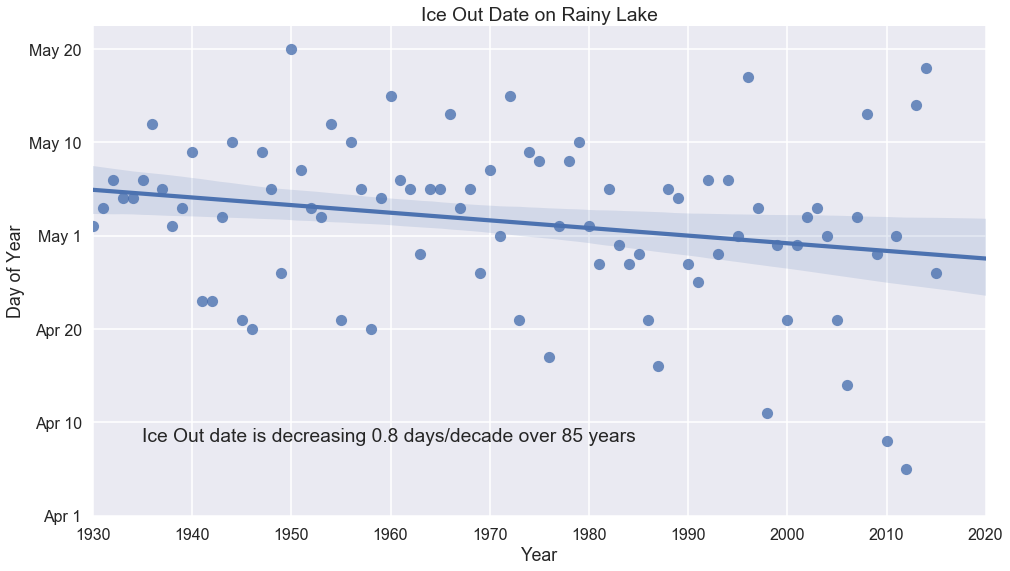

In [15]:
plt.figure(figsize=(16,9))

sns.regplot(x=RL_ICEOUT.index.year,
            y=RL_ICEOUT.index.dayofyear,
            data = IO_DOY,
            ci=90,
            scatter=True,
            fit_reg = True)

plt.title('Ice Out Date on Rainy Lake')
plt.ylabel('Day of Year')
plt.xlabel('Year')
plt.xlim(1930,2020)
plt.yticks([92,102,112,122,132,142],
           ['Apr 1','Apr 10','Apr 20','May 1','May 10','May 20']);
plt.annotate('Ice Out date is decreasing 0.8 days/decade over 85 years',xy=(1935,100))

fname = '../images/IceOutTrendLine.png'

plt.savefig(fname)
!convert $fname -trim $fname

In [16]:
import statsmodels.api as sm

x = RL_ICEOUT.index.year
y = RL_ICEOUT.index.dayofyear

regressors = sm.tools.tools.add_constant(x)
r = sm.OLS(y,regressors).fit()

print(r.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     4.913
Date:                Tue, 07 Mar 2017   Prob (F-statistic):             0.0294
Time:                        10:30:27   Log-Likelihood:                -305.00
No. Observations:                  86   AIC:                             614.0
Df Residuals:                      84   BIC:                             618.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        284.7548     72.785      3.912      0.0

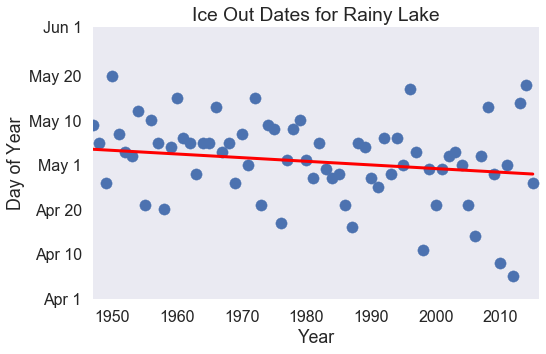

In [17]:
ypred = r.params[0] + r.params[1]*x

plt.figure(figsize=(8,5))
plt.plot(x, ypred, 'r', lw=3)
plt.scatter(x, y)
plt.xlim(1947,2016)
plt.ylim(95,145)
plt.yticks([92,102,112,122,132,142,153],
           ['Apr 1','Apr 10','Apr 20','May 1','May 10','May 20','Jun 1'])
plt.title('Ice Out Dates for Rainy Lake')
plt.xlabel('Year')
plt.ylabel('Day of Year')
plt.grid()

In [18]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
prstd, xa, xb = wls_prediction_std(r, exog=[1,2016], alpha=0.1)

day = r.predict([1.0,2016.0])

idate = datetime.datetime(2017,1,1) + datetime.timedelta(days=day[0])
print('Average DOY for Ice Out: {0:.1f}'.format(day[0]))
print(idate.strftime('Average date for Ice Out: %b %d'))
print('Std Dev: {0:.1f} days'.format(prstd[0]))
print('90% confidence interval: -{0:.1f} to +{0:.1f} days'.format(day[0]-xa[0],xb[0]-day[0]))

Average DOY for Ice Out: 119.9
Average date for Ice Out: Apr 30
Std Dev: 8.7 days
90% confidence interval: -14.5 to +14.5 days


## Weather Data


[GHCN (Global Historical Climatology Network) – Daily Documentation](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf)

### Read Data Set

In [19]:
# read temperature data series
wdata = pd.read_csv('../data/893229.csv',index_col=2,parse_dates=True);
for col in wdata.columns:
    wdata.ix[wdata[col]==-9999,col] = float('nan')
    
# extract station and station name
STATION = wdata.ix[0,0]
STATION_NAME = wdata.ix[0,1]
print('STATION: ',STATION)
print('STATION_NAME: ',STATION_NAME)

# the data set has a large gap, so slice to 1948 and forward
wdata = wdata['1948':'2016']

# keep key columns
cols = ['PRCP','SNWD','SNOW','TMAX','TMIN','WESD','AWND']
wdata = wdata[cols]

# convert units
wdata['PRCP'] = 25.4*wdata['PRCP']         # inches to mm
wdata['SNWD'] = 25.4*wdata['SNWD']         # inches to mm
wdata['SNOW'] = 25.4*wdata['SNOW']         # inches to mm
wdata['TMAX'] = (wdata['TMAX']-32.0)/1.8   # F to C
wdata['TMIN'] = (wdata['TMIN']-32.0)/1.8   # F to C
wdata['WESD'] = 25.4*wdata['WESD']         # inches to mm
wdata['AWND'] = 0.44704*wdata['AWND']      # mph to m/s

desc = {
    'PRCP':('Precipitation','mm'),
    'SNWD':('Snow Depth','mm'),
    'SNOW':('Snowfall','mm'),
    'ACMH':('Average Cloudiness Midnight to Midnight','%'), 
    'TMAX':('Maximum Temperature','degrees C'),
    'TMIN':('Minimum Temperature','degrees C'),
    'WESD':('Water Equivalent of Snow on the Ground','mm'),
    'AWND':('Average Daily Wind Speed','meters per second'),
    'Snow on Ground':('Snow on Ground','days')
}

# logical variable to determine if snow is on the ground
wdata['Snow on Ground'] = wdata['SNWD'] > 0
wdata['SNWD'].replace(0,np.NaN)

# add calendar year and month columns
wdata['Month'] = wdata.index.month
wdata['Year'] = wdata.index.year

# add water year and month columns
wdata['Water Year'] = wdata.index.shift(+4,freq='M').year
wdata['Water Month'] = wdata.index.shift(+4,freq='M').month

# peek at data
wdata.tail()

STATION:  GHCND:USW00014918
STATION_NAME:  INTERNATIONAL FALLS INTERNATIONAL AIRPORT MN US


,PRCP,SNWD,SNOW,TMAX,TMIN,WESD,AWND,Snow on Ground,Month,Year,Water Year,Water Month
DATE,,,,,,,,,,,,
2016-12-27,0.000,279.40,0.00,-11.666667,-21.111111,NaN,2.279904,True,12,2016,2017,3
2016-12-28,2.540,279.40,35.56,-3.333333,-16.666667,NaN,3.084576,True,12,2016,2017,3
2016-12-29,0.254,279.40,5.08,-5.000000,-11.666667,NaN,5.900928,True,12,2016,2017,3
2016-12-30,4.064,248.92,86.36,-11.666667,-13.888889,NaN,2.503424,True,12,2016,2017,3
2016-12-31,0.762,330.20,10.16,-7.777778,-27.777778,NaN,2.503424,True,12,2016,2017,4


In [20]:
# Regression plot using Seaborn

def regplot(q,data):
    data['Year'] = data.index.tolist()
    sns.regplot(x='Year', y=q, data = data,
            ci=90, scatter=True, fit_reg = True)

    sns.set_context("notebook", font_scale=1.5)
    plt.title(desc[q][0])
    plt.ylabel(desc[q][1])
    plt.xlabel('Year')
    plt.xlim(1948,2017)
    plt.ylim(0,1.1*plt.ylim()[1])

### ENSO Data

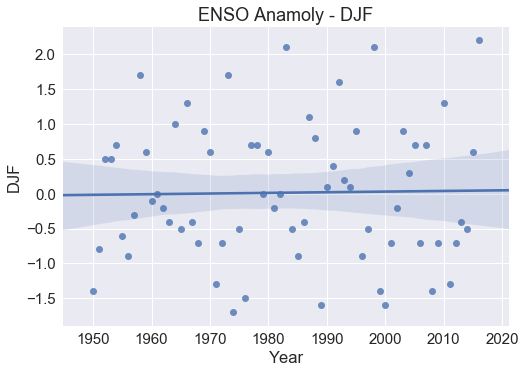

In [102]:
enso = pd.read_csv("ENSO.csv",index_col="Year")
enso.head()
x = enso.index.tolist()
y = enso['DJF'].tolist()
df = pd.DataFrame(y, index=x, columns=['DJF'])
df['Year'] = df.index
sns.regplot(x='Year',y = 'DJF', data=df)
plt.title('ENSO Anamoly - DJF')

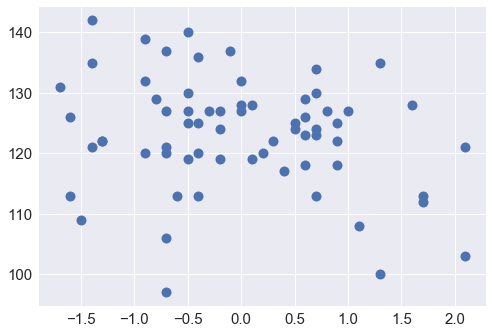

In [43]:
u = enso
u['IO_DOY'] = IO_DOY
plt.plot(u['DJF'],u['IO_DOY'],'.',ms=20)

### Annual Mean Wind Speed

According to Vautard, et al. (2010), annual mean wind speeds have declined at a large majority of stations located throughout the Northern hemisphere. In North America they report a decline of -0.07 meters/second per decade. 

The following calculations demonstrate a decline of -0.3 meters/second per decade for annual mean wind speed found using data reported at International Falls, MN.

1. Vautard, Robert, Julien Cattiaux, Pascal Yiou, Jean-Noël Thépaut, and Philippe Ciais. "Northern Hemisphere atmospheric stilling partly attributed to an increase in surface roughness." Nature Geoscience 3, no. 11 (2010): 756-761.

                            OLS Regression Results                            
Dep. Variable:                   AWND   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     56.16
Date:                Tue, 07 Mar 2017   Prob (F-statistic):           2.36e-08
Time:                        10:33:16   Log-Likelihood:                 5.9908
No. Observations:                  32   AIC:                            -7.982
Df Residuals:                      30   BIC:                            -5.050
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Year          -0.0297      0.004     -7.494      0.0

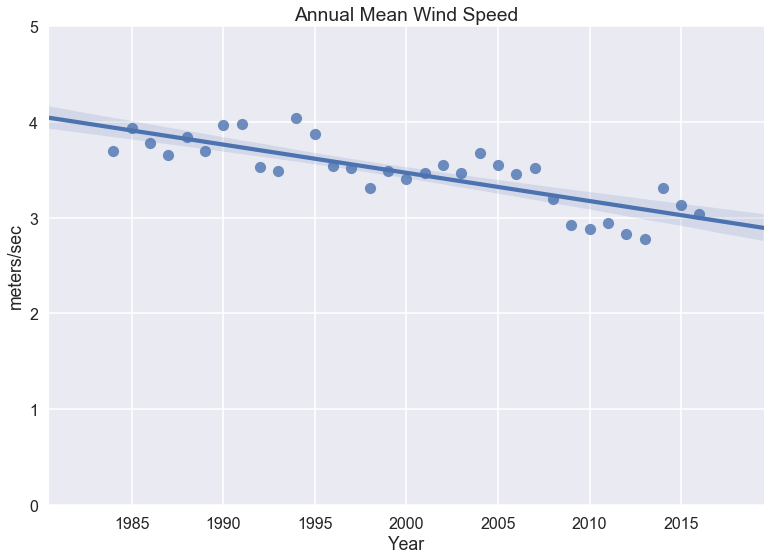

In [23]:
data = pd.DataFrame(wdata.groupby('Year')['AWND'].mean()).dropna()

data['Year'] = data.index.tolist()
sns.regplot(x='Year', y='AWND', data = data,
            ci=90, scatter=True, fit_reg = True)
plt.ylim(0,5)
plt.title('Annual Mean Wind Speed')
plt.ylabel('meters/sec')

import statsmodels.api as sm
data['Ones'] = np.ones((len(data),))
Y = data.AWND[:-1]
X = data[['Year','Ones']][:-1]
result = sm.OLS(Y,X).fit()
print(result.summary())

fname = '../images/WindTrendLine.png'

plt.savefig(fname)
!convert $fname -trim $fname

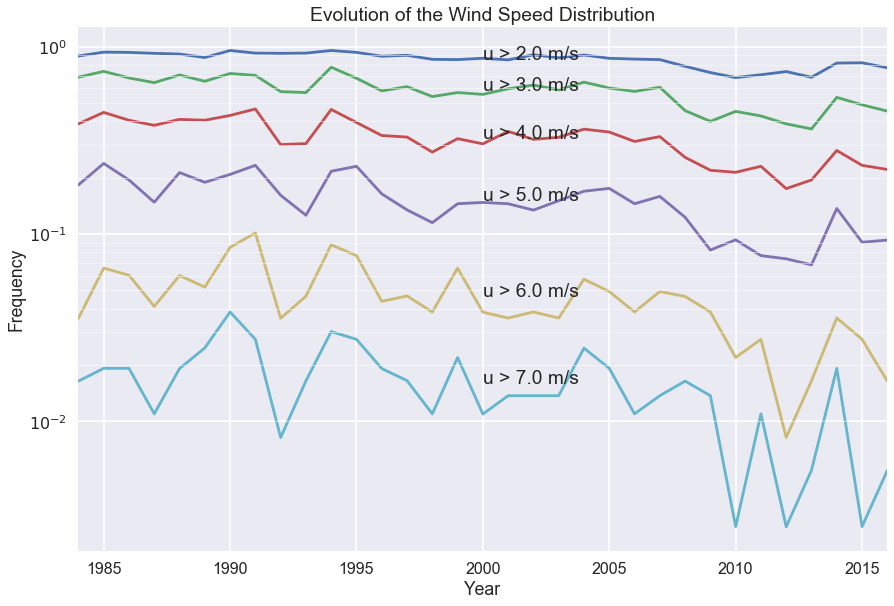

In [24]:
data = wdata[['AWND','Year','Month']].dropna()

#plt.figure(figsize=(8,12))

uList = [2,3,4,5,6,7]
for u in uList:
    data[u] = data['AWND'] > u
    p = data.groupby('Year')[u].value_counts(normalize=True)
    p[:,True].plot(logy=True)
    plt.text(2000,p[:,True].mean(),'u > {0:.1f} m/s'.format(u))
    
for d in [.9,.8,.7,.6,.5,.4,.3,.2,.1]:
    plt.plot(plt.xlim(),[d,d],'w',lw=.5)
    plt.plot(plt.xlim(),[0.1*d,0.1*d],'w',lw=.5)
    
plt.ylabel('Frequency')
plt.title('Evolution of the Wind Speed Distribution')
plt.tight_layout()

fname = '../images/WindDistribution.png'
plt.savefig(fname)
!convert $fname -trim $fname

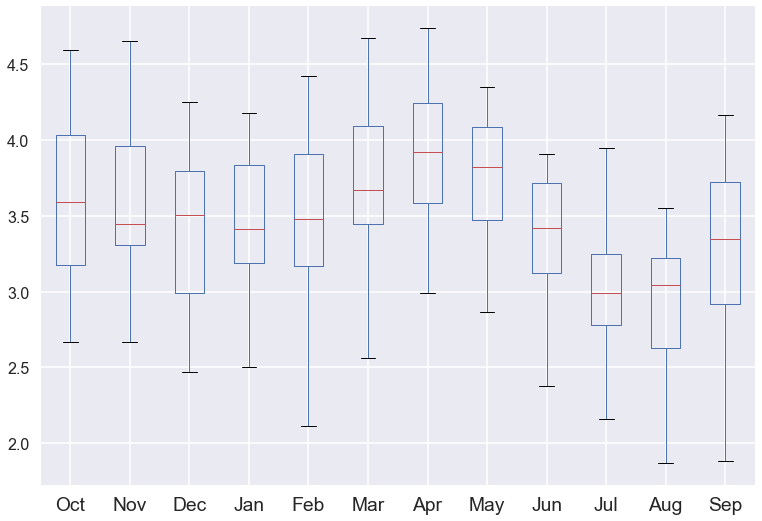

In [25]:
awnd = wdata.groupby(['Water Year','Water Month'])['AWND'].mean()
awnd.unstack().boxplot()
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],
          ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);

### Daily Temperatures

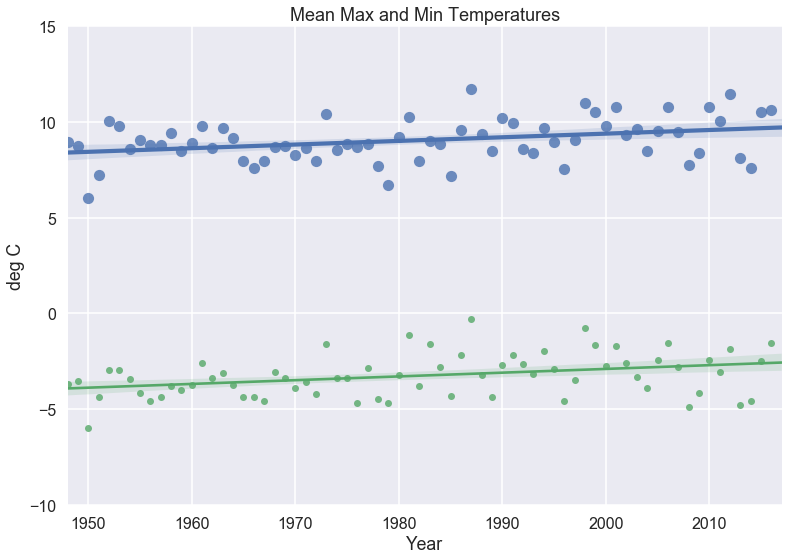

In [26]:
data = pd.DataFrame(wdata.groupby(wdata.index.year)['TMAX'].mean())
regplot('TMAX',data)

data = pd.DataFrame(wdata.groupby(wdata.index.year)['TMIN'].mean())
regplot('TMIN',data)

plt.ylim(-10,15)
plt.title('Mean Max and Min Temperatures')
plt.ylabel('deg C')

fname = '../images/TempTrend.png'

plt.savefig(fname)
!convert $fname -trim $fname

### There are fewer cold days

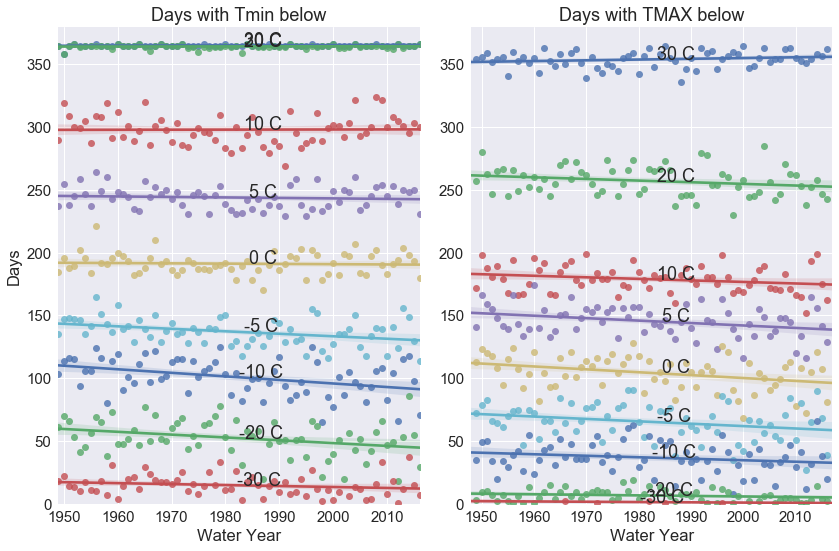

In [27]:
Tlist = [30,20,10,5,0,-5,-10,-20,-30]

plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
for T in Tlist:
    data = wdata[wdata['TMIN'] < T]
    data = pd.DataFrame(data.groupby('Water Year')['TMIN'].count())
    data = data.ix[1949:2016]
    regplot('TMIN',data)
    dave = np.mean(data.index.tolist())
    Tave = data['TMIN'].mean()
    plt.text(dave,Tave,'{0:3d} C'.format(T))

plt.title('Days with Tmin below')
plt.xlim(1949,2016)
plt.ylim(0,380)
plt.xlabel('Water Year')
plt.ylabel('Days')

plt.subplot(1,2,2)
for T in Tlist:
    data = wdata[wdata['TMAX'] < T]
    data = pd.DataFrame(data.groupby('Water Year')['TMAX'].count())
    data = data.ix[1949:2016]
    regplot('TMAX',data)
    dave = np.mean(data.index.tolist())
    Tave = data['TMAX'].mean()
    plt.text(dave,Tave,'{0:3d} C'.format(T))

plt.title('Days with TMAX below')
plt.ylim(0,380)
plt.xlabel('Water Year')
plt.ylabel('')
plt.tight_layout()

fname = '../images/TempColdTrend.png'

plt.savefig(fname)
!convert $fname -trim $fname

### There are more warm days

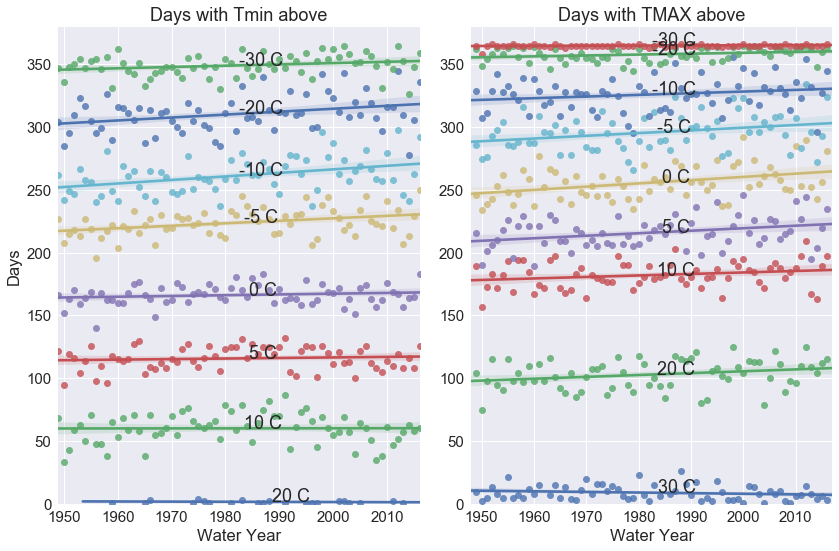

In [28]:
Tlist = [30,20,10,5,0,-5,-10,-20,-30]

plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
for T in Tlist:
    data = wdata[wdata['TMIN'] > T]
    data = pd.DataFrame(data.groupby('Water Year')['TMIN'].count())
    data = data.ix[1949:2016]
    if len(data) > 0:
        regplot('TMIN',data)
        dave = np.mean(data.index.tolist())
        Tave = data['TMIN'].mean()
        plt.text(dave,Tave,'{0:3d} C'.format(T))

plt.title('Days with Tmin above')
plt.xlim(1949,2016)
plt.ylim(0,380)
plt.xlabel('Water Year')
plt.ylabel('Days')

plt.subplot(1,2,2)
for T in Tlist:
    data = wdata[wdata['TMAX'] > T]
    data = pd.DataFrame(data.groupby('Water Year')['TMAX'].count())
    data = data.ix[1949:2016]
    regplot('TMAX',data)
    dave = np.mean(data.index.tolist())
    Tave = data['TMAX'].mean()
    plt.text(dave,Tave,'{0:3d} C'.format(T))

plt.title('Days with TMAX above')
plt.ylim(0,380)
plt.xlabel('Water Year')
plt.ylabel('')
plt.tight_layout()

fname = '../images/TempWarmdTrend.png'
plt.savefig(fname)
!convert $fname -trim $fname

### Snow Cover

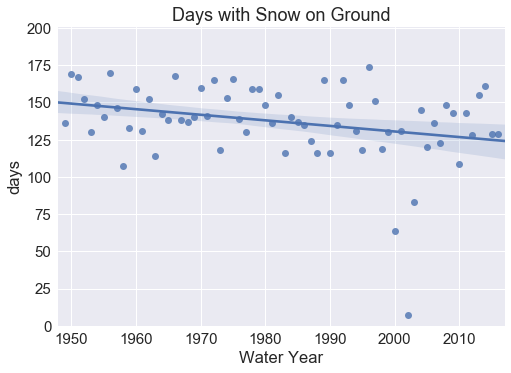

In [29]:
data = pd.DataFrame(wdata.groupby('Water Year')['Snow on Ground'].sum())
data = data.ix[1949:2016]

regplot('Snow on Ground',data)
plt.title('Days with Snow on Ground')
plt.xlabel('Water Year')

fname = '../images/SnowOnGround.png'

plt.savefig(fname)
!convert $fname -trim $fname

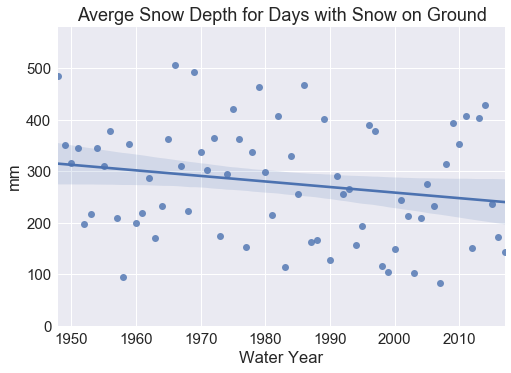

In [30]:
data = wdata[wdata['SNWD'] > 0]
data = pd.DataFrame(data.groupby('Water Year')['SNWD'].mean())

regplot('SNWD',data)
plt.title('Averge Snow Depth for Days with Snow on Ground')
plt.xlabel('Water Year')

fname = '../images/SnowDepth.png'

plt.savefig(fname)
!convert $fname -trim $fname

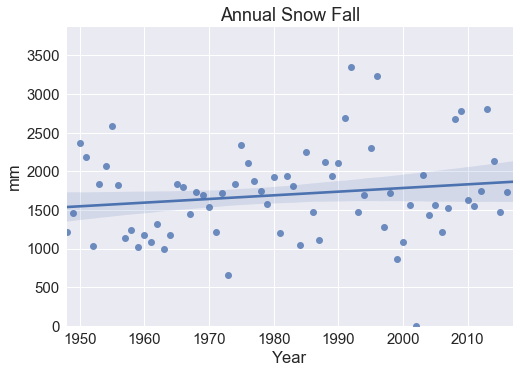

In [31]:
data = pd.DataFrame(wdata.groupby(wdata.index.year)['SNOW'].sum())
regplot('SNOW',data)
plt.title('Annual Snow Fall')

fname = '../images/SnowFall.png'
plt.savefig(fname)
!convert $fname -trim $fname

### Total Annual Precipitation has been Steady

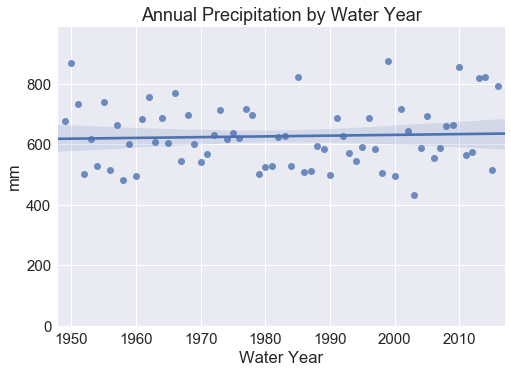

In [32]:
data = pd.DataFrame(wdata.groupby('Water Year')['PRCP'].sum())
data = data.ix['1949':'2016']
regplot('PRCP',data)
plt.title('Annual Precipitation by Water Year')
plt.xlabel('Water Year')

fname = '../images/PrcpTrend.png'
plt.savefig(fname)
!convert $fname -trim $fname

### Seasonal Precipitation Patterns

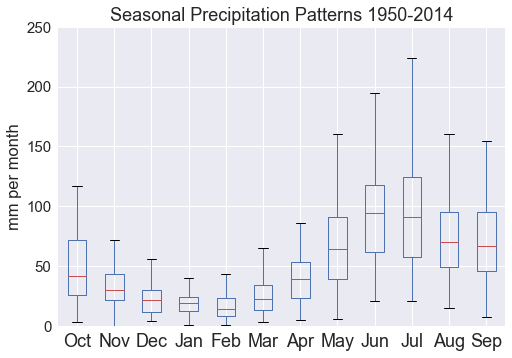

In [33]:
prcp = wdata.groupby(['Water Year','Water Month'])['PRCP'].sum()
#print(prcp.unstack())
prcp.unstack().boxplot()
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],
          ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
plt.ylim(0,250)
plt.ylabel('mm per month')
plt.title('Seasonal Precipitation Patterns 1950-2014')

fname = '../images/PrcpSeasonal.png'
plt.savefig(fname)
!convert $fname -trim $fname

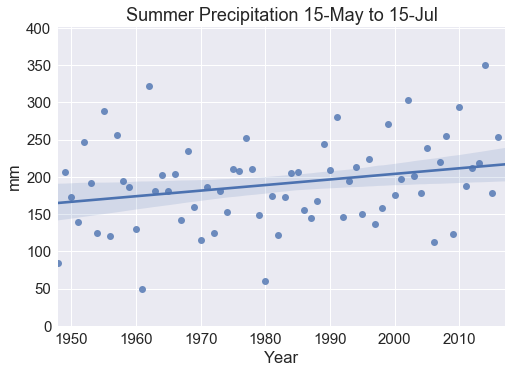

In [34]:
data = wdata.loc[(wdata.index.dayofyear >= 136) & (wdata.index.dayofyear <= 197)]
data = pd.DataFrame(data.groupby('Water Year')['PRCP'].sum())
regplot('PRCP',data)
plt.title('Summer Precipitation 15-May to 15-Jul')
data.head()

fname = '../images/PrcpSummer.png'
plt.savefig(fname)
!convert $fname -trim $fname

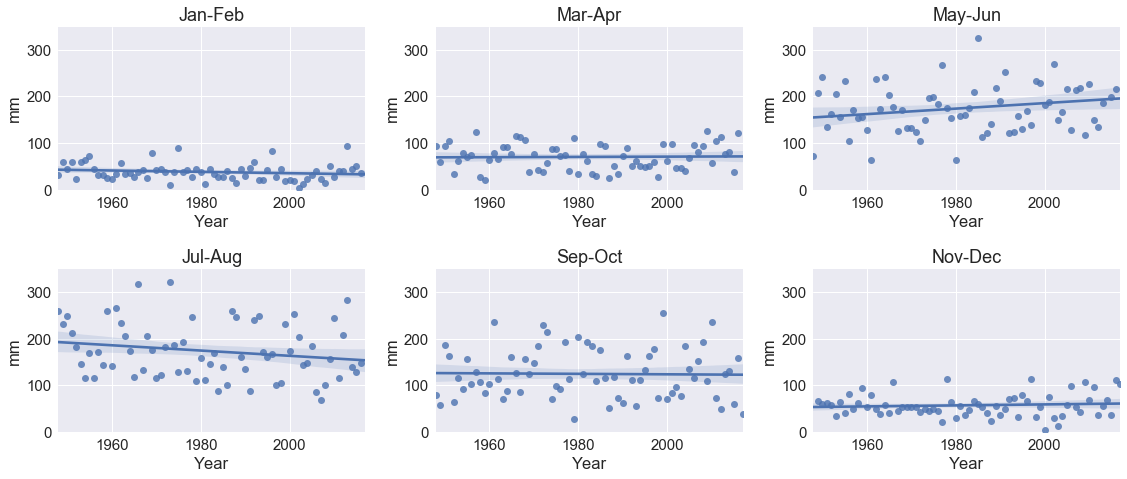

In [35]:
doy = [1,61,122,183,244,305,366]
per = ['Jan-Feb','Mar-Apr','May-Jun','Jul-Aug','Sep-Oct','Nov-Dec']

plt.figure(figsize=(16,7))
plt.subplot(2,3,1)
for k in range(0,len(per)):
    plt.subplot(2,3,k+1)
    data = wdata.loc[(wdata.index.dayofyear >= doy[k]) & (wdata.index.dayofyear <= doy[k+1])]
    data = pd.DataFrame(data.groupby('Water Year')['PRCP'].sum())
    regplot('PRCP',data)
    plt.title(per[k])
    plt.ylim(0,350)
    
plt.tight_layout() 

fname = '../images/PrcpChange.png'
plt.savefig(fname)
!convert $fname -trim $fname

## Pacific Decadal Oscillation

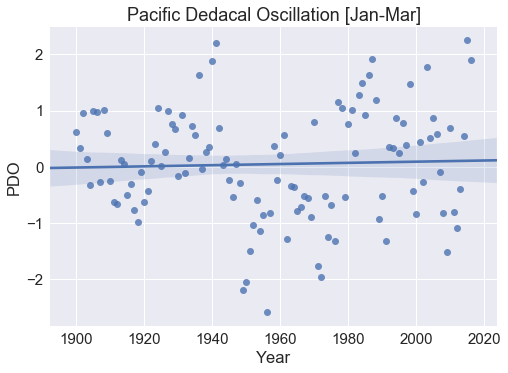

In [233]:
pdoCSV = pd.read_csv("../data/Pacific Decadal Oscillation.csv",index_col="YEAR")

mdict= {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,
        'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}

pdoSeries = pd.Series()
for yr in pdoCSV.index:
    for mo in pdoCSV.columns:
        pdoSeries.set_value(datetime.datetime(yr,mdict[mo],1),pdoCSV.ix[yr,mo])


pdo = pd.DataFrame(pdoSeries, columns=['PDO'])
pdo['Month'] = pdo.index.month
pdo = pdo.loc[pdo['Month'] <= 3]
pdo = pdo.groupby(pdo.index.year).mean()
pdo['Year'] = pdo.index
pdo.drop('Month',axis=1,inplace=True)
sns.regplot(x='Year',y = 'PDO', data=pdo)
plt.title('Pacific Dedacal Oscillation [Jan-Mar]')


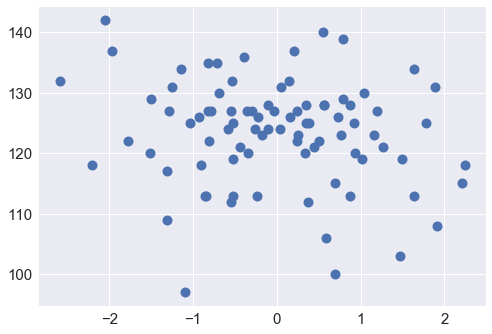

In [237]:
u = pdo
u['IO_DOY'] = IO_DOY
plt.plot(u['PDO'],u['IO_DOY'],'.',ms=20)

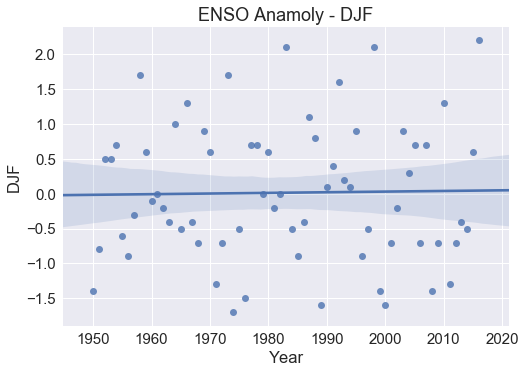

In [200]:
x = enso.index.tolist()
y = enso['DJF'].tolist()
df = pd.DataFrame(y, index=x, columns=['DJF'])
df['Year'] = df.index
sns.regplot(x='Year',y = 'DJF', data=df)
plt.title('ENSO Anamoly - DJF')

## Forecasting Ice Out

### Verify Data Set

In [609]:
display(wdata.head())

,PRCP,SNWD,SNOW,TMAX,TMIN,WESD,AWND,Snow on Ground,Month,Year,Water Year,Water Month
DATE,,,,,,,,,,,,
1948-01-01,0.000,533.4,0.00,-8.888889,-30.000000,NaN,NaN,True,1,1948,1948,4
1948-01-02,0.000,533.4,0.00,-5.555556,-12.222222,NaN,NaN,True,1,1948,1948,4
1948-01-03,1.524,558.8,40.64,-5.000000,-10.555556,NaN,NaN,True,1,1948,1948,4
1948-01-04,0.000,558.8,0.00,-4.444444,-8.333333,NaN,NaN,True,1,1948,1948,4
1948-01-05,0.762,558.8,7.62,-0.555556,-10.000000,NaN,NaN,True,1,1948,1948,4


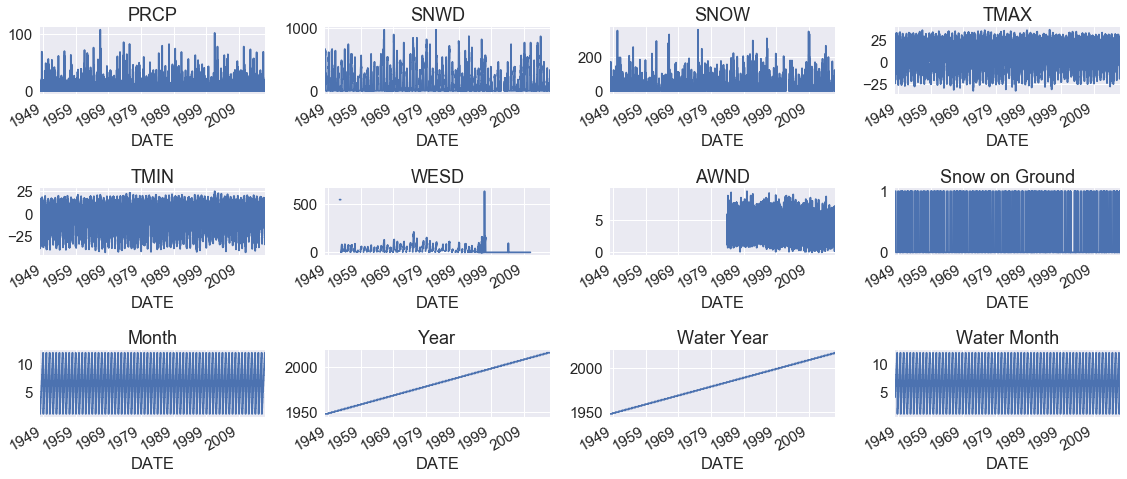

In [433]:
def colplot(col):
    wdata[col].plot()
    plt.title(col)

plt.figure(figsize=(16,7))
plt.subplot(3,4,1)
k = 0
for col in wdata.columns:
    k += 1
    plt.subplot(3,4,k)
    colplot(col)
plt.tight_layout()

## Feature Selection

We seek a correlation between late Winter and early Spring temperature records at International Falls to ice-out dates on Rainy Lake. For this purpose we create additional regressors that should correlate with ice melt. 

$T^{max+}_k$ (respectively $T^{max-}_k$ is the difference by which the daily high temperature $T^{max}_k$ is above (respectively below) freezing. Since temperature must either be above or below the melting point,

$$T^{max}_k = T^{max+}_k + T^{max-}_k$$ 

where

\begin{align*}
T^{max+}_k & = \max(0,T^{max}_k) \\
T^{max-}_k & = \min(0,T^{max}_k)
\end{align*}

showing the linear dependence among these three regressors. The intuition is that a high mean value of $T^{max+}_k$ in late Winter and early Spring would correlate with an early ice-out date.

Similary, we define $T^{min+}_k$ (respectively $T^{min-}_k$ as 

$$T^{min}_k = T^{min+}_k + T^{min-}_k$$ 

where

\begin{align*}
T^{min+}_k & = \max(0,T^{min}_k) \\
T^{min-}_k & = \min(0,T^{min}_k)
\end{align*}

Here the intuition is that very negative values of $T^{min-}_k$ would correlate with late ice-out dates. Conversely, positive values of $T^{min+}_k$ would suggest periods of ice melt and therefore earlier ice-out.


\begin{align*}
Pred & = \beta_0 + 
\beta_1 \frac{1}{55} \sum_{k=50}^{105} \max(0,T^{max}_k) +
\beta_2 \frac{1}{55} \sum_{k=50}^{105} \max(0,T^{min}_k) + 
\beta_3 \frac{1}{55} \sum_{k=50}^{105} \min(0,T^{min}_k)
\end{align*}


### Empirical Dimensionality Reduction

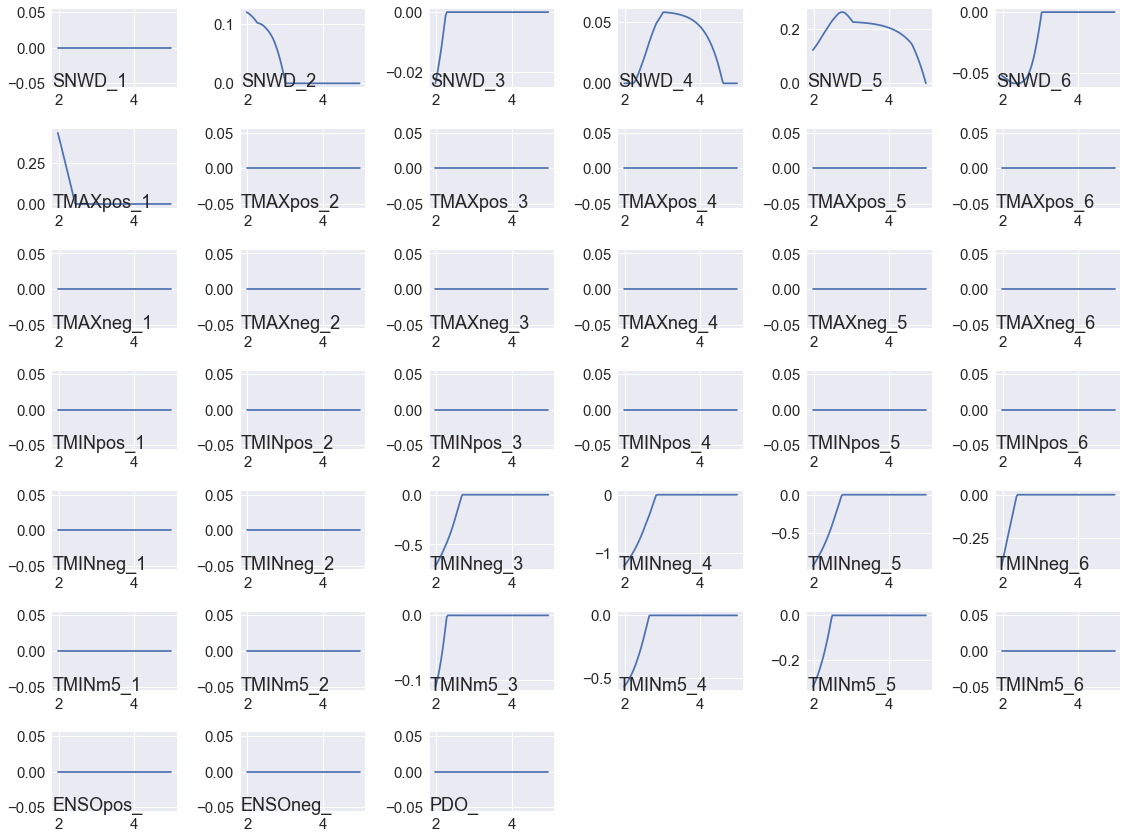

In [234]:
# data series to fit
Y = IO_DOY.ix[1950:2015]

# begin building a dataframe of regessors
TEMP = wdata[['Water Year','Water Month']].copy()

# create feature set
TEMP['SNWD'] = wdata['SNWD'].copy()
TEMP['TMAXpos'] = wdata['TMAX'].copy().apply(lambda x: max(0,x))
TEMP['TMAXneg'] = wdata['TMAX'].copy().apply(lambda x: min(0,x))
TEMP['TMINpos'] = wdata['TMIN'].copy().apply(lambda x: max(0,x))
TEMP['TMINneg'] = wdata['TMIN'].copy().apply(lambda x: min(0,x))
TEMP['TMINm5'] = wdata['TMIN'].copy().apply(lambda x: min(0,5+x))
TEMP.fillna(0,inplace=True)

# create regressor by average over water months
X = TEMP.loc[TEMP['Water Month'] <= 6].copy()
X = X.groupby(['Water Year','Water Month']).mean().unstack()
X['ENSOpos'] = enso['DJF'].copy().apply(lambda x: max(0,x))
X['ENSOneg'] = enso['DJF'].copy().apply(lambda x: min(0,x))
X['PDO'] = pdo['PDO'].copy()
    
labels = ['{0}_{1}'.format(X.columns.levels[0][i],X.columns.levels[1][j])
           for i,j in zip(X.columns.labels[0],X.columns.labels[1])]
    
from sklearn.linear_model import enet_path

alphas, coefs, _ = enet_path(X.ix[Y.index], Y, l1_ratio = 0.5, normalize=True)

plt.figure(figsize=(16,12))
plt.subplot(7,6,1)
for k in range(0,len(labels)):
    plt.subplot(7,6,k+1)
    plt.plot(np.log10(alphas),coefs[k])
    plt.annotate(labels[k],xy=(plt.xlim()[0],plt.ylim()[0]))

plt.tight_layout()

fname = '../images/IceOutFeatures.png'
plt.savefig(fname)
!convert $fname -trim $fname

## Predictor Fit - Elastic Net Regression with Cross-Validation

### Reduced Feature Set

The next step is to remove features which don't add to the regression.

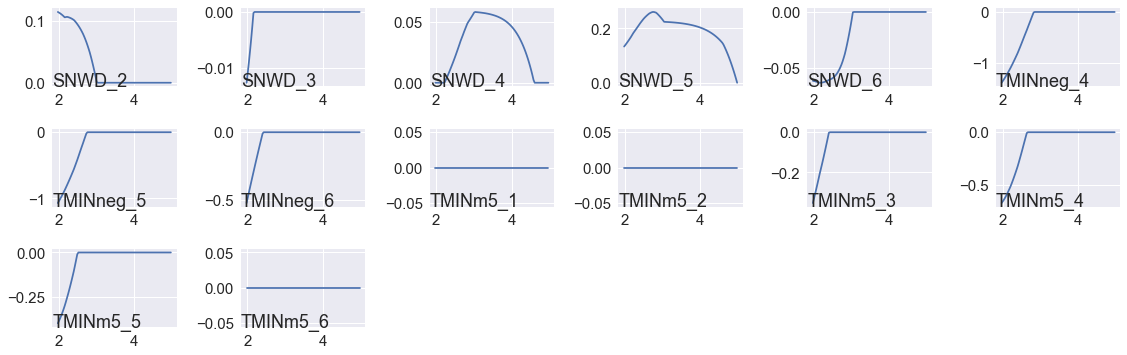

In [124]:
# create regressor by average over water months
X = TEMP.loc[TEMP['Water Month'] <= 6].copy()
X = X.groupby(['Water Year','Water Month']).mean().unstack()
#X['ENSO'] = enso['DJF']

# remove features that don't add to the regression
X.drop(('SNWD',1),axis=1,inplace=True)
X.drop('TMAXpos',axis=1,inplace=True)
X.drop('TMAXneg',axis=1,inplace=True)
X.drop('TMINpos',axis=1,inplace=True)
#X.drop('TMINneg',axis=1,inplace=True)
#X.drop(('TMINm5',1),axis=1,inplace=True)
#X.drop(('TMINm5',2),axis=1,inplace=True)
X.drop(('TMINneg',1),axis=1,inplace=True)
X.drop(('TMINneg',2),axis=1,inplace=True)
X.drop(('TMINneg',3),axis=1,inplace=True)
    
labels = ['{0}_{1}'.format(X.columns.levels[0][i],X.columns.levels[1][j])
           for i,j in zip(X.columns.labels[0],X.columns.labels[1])]

from sklearn.linear_model import enet_path

alphas, coefs, _ = enet_path(X.ix[Y.index], Y, l1_ratio = 0.5, normalize=True)

plt.figure(figsize=(16,10))
plt.subplot(6,6,1)
for k in range(0,len(labels)):
    plt.subplot(6,6,k+1)
    plt.plot(np.log10(alphas),coefs[k])
    plt.annotate(labels[k],xy=(plt.xlim()[0],plt.ylim()[0]))

plt.tight_layout()

fname = '../images/IceOutReducedFeaturesApril.png'
plt.savefig(fname)
!convert $fname -trim $fname

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=1000, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)
alpha        =   1.43704
score        =   0.55698
beta_SNWD_2  =   0.05967
beta_SNWD_3  =  -0.00936
beta_SNWD_4  =  -0.01091
beta_SNWD_5  =   0.01087
beta_SNWD_6  =  -0.00469
beta_TMINneg_4 =  -0.59126
beta_TMINneg_5 =  -0.49001
beta_TMINneg_6 =  -0.91675
beta_TMINm5_1 =  -0.00000
beta_TMINm5_2 =  -0.00000
beta_TMINm5_3 =  -0.00000
beta_TMINm5_4 =  -0.25166
beta_TMINm5_5 =  -0.00000
beta_TMINm5_6 =  -0.00000
intercept    =  84.23038


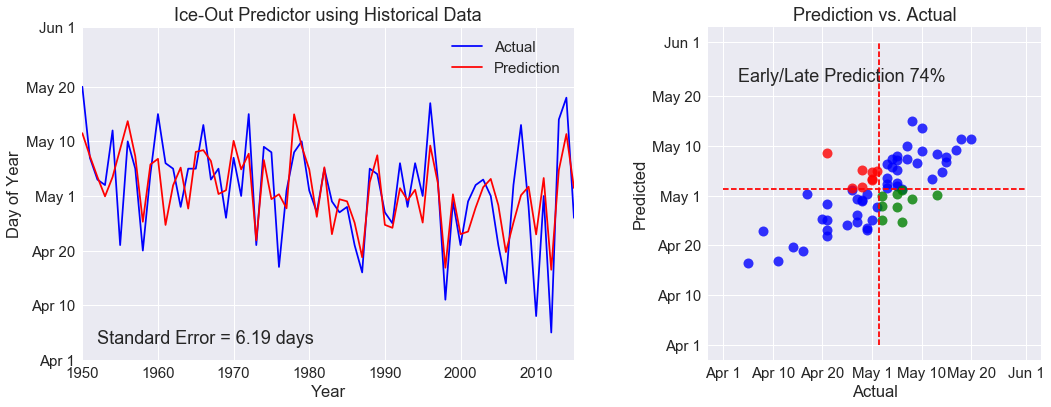

In [168]:
from sklearn.linear_model import ElasticNetCV

# Estimate alpha by plotting the elastic path regression as a function of alpha

clf = ElasticNetCV(cv = 10, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_alphas=1000)
model = clf.fit(X.ix[Y.index],Y)
print(model)
print("alpha        = {0:9.5f}".format(clf.alpha_))
print("score        = {0:9.5f}".format(clf.score(X.ix[Y.index],Y)))
for k in range(0,len(labels)):
    print("beta_{0:<7s} = {1:9.5f}".format(labels[k],clf.coef_[k]))
print("intercept    = {0:9.5f}".format(clf.intercept_))

# Predictions
P = pd.Series(clf.predict(X.ix[Y.index]),index=Y.index);

# time trace
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
Y.plot(color='b')
P.plot(color='r')
plt.legend(['Actual','Prediction'])
plt.title('Ice-Out Predictor using Historical Data')
plt.ylabel('Day of Year')
plt.xlabel('Year')
plt.yticks([92,102,112,122,132,142,153],
           ['Apr 1','Apr 10','Apr 20','May 1','May 10','May 20','Jun 1'])
plt.annotate('Standard Error = {0:.2f} days'.format((P-Y).std()),
            xy = [1952,95])

# classification
aio = 123.4
k1 = (P>=aio) & (Y>=aio)
k2 = (P<=aio) & (Y<=aio)
k3 = (P>aio) & (Y<aio)
k4 = (P<aio) & (Y>aio)

plt.subplot(1,2,2)
plt.plot(Y[k1|k2],P[k1|k2],'bo',ms=10,alpha=0.8)
plt.plot(Y[k3],P[k3],'ro',ms=10,alpha=0.8)
plt.plot(Y[k4],P[k4],'go',ms=10,alpha=0.8)

# add visual guides
plt.plot([92,153],[aio,aio],'r--')
plt.plot([aio,aio],[92,153],'r--')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction vs. Actual')
plt.axis('square')
plt.yticks([92,102,112,122,132,142,153],
           ['Apr 1','Apr 10','Apr 20','May 1','May 10','May 20','Jun 1'])
plt.xticks([92,102,112,122,132,142,153],
           ['Apr 1','Apr 10','Apr 20','May 1','May 10','May 20','Jun 1'])
plt.annotate('Early/Late Prediction {0:.0f}%'.format(100*(sum(k1)+sum(k2))/len(P)),xy=(95,145))

plt.tight_layout()

fname = '../images/IceOut_PredictionApril.png'
plt.savefig(fname)
!convert $fname -trim $fname

### Reduced Feature Set - March 1st Estimator

The next step is to remove features which don't add to the regression.

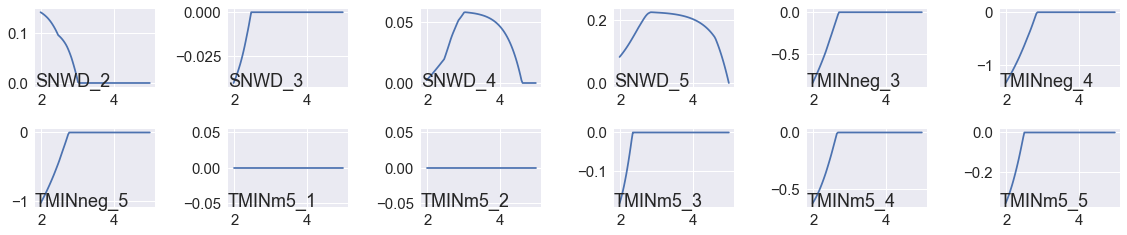

In [171]:
# create regressor by average over water months
X = TEMP.loc[TEMP['Water Month'] <= 5].copy()
X = X.groupby(['Water Year','Water Month']).mean().unstack()

# remove features that don't add to the regression
X.drop(('SNWD',1),axis=1,inplace=True)
X.drop('TMAXpos',axis=1,inplace=True)
X.drop('TMAXneg',axis=1,inplace=True)
X.drop('TMINpos',axis=1,inplace=True)
X.drop(('TMINneg',1),axis=1,inplace=True)
X.drop(('TMINneg',2),axis=1,inplace=True)
#X.drop(('TMINneg',3),axis=1,inplace=True)
    
labels = ['{0}_{1}'.format(X.columns.levels[0][i],X.columns.levels[1][j])
           for i,j in zip(X.columns.labels[0],X.columns.labels[1])]

from sklearn.linear_model import enet_path

alphas, coefs, _ = enet_path(X.ix[Y.index], Y, l1_ratio = 0.5, normalize=True)

plt.figure(figsize=(16,10))
plt.subplot(6,6,1)
for k in range(0,len(labels)):
    plt.subplot(6,6,k+1)
    plt.plot(np.log10(alphas),coefs[k])
    plt.annotate(labels[k],xy=(plt.xlim()[0],plt.ylim()[0]))

plt.tight_layout()

fname = '../images/IceOutReducedFeaturesMarch.png'
plt.savefig(fname)
!convert $fname -trim $fname

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=1000, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)
alpha        =   1.96816
score        =   0.44809
beta_SNWD_2  =   0.06131
beta_SNWD_3  =  -0.00605
beta_SNWD_4  =  -0.01549
beta_SNWD_5  =   0.01588
beta_TMINneg_3 =  -0.00000
beta_TMINneg_4 =  -0.66686
beta_TMINneg_5 =  -0.52646
beta_TMINm5_1 =  -0.00000
beta_TMINm5_2 =   0.00000
beta_TMINm5_3 =  -0.00000
beta_TMINm5_4 =  -0.24025
beta_TMINm5_5 =  -0.00000
intercept    =  90.65492


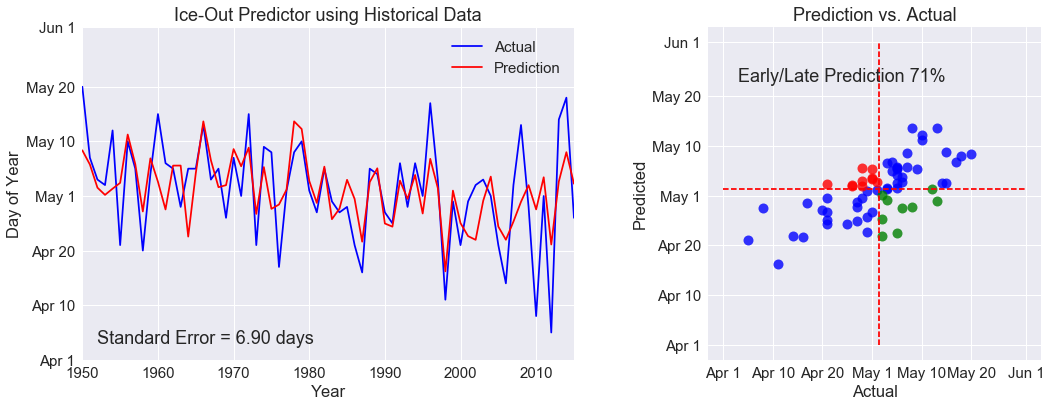

In [173]:
from sklearn.linear_model import ElasticNetCV

# Estimate alpha by plotting the elastic path regression as a function of alpha

clf = ElasticNetCV(cv = 10, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_alphas=1000)
model = clf.fit(X.ix[Y.index],Y)
print(model)
print("alpha        = {0:9.5f}".format(clf.alpha_))
print("score        = {0:9.5f}".format(clf.score(X.ix[Y.index],Y)))
for k in range(0,len(labels)):
    print("beta_{0:<7s} = {1:9.5f}".format(labels[k],clf.coef_[k]))
print("intercept    = {0:9.5f}".format(clf.intercept_))

# Predictions
P = pd.Series(clf.predict(X.ix[Y.index]),index=Y.index);

# time trace
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
Y.plot(color='b')
P.plot(color='r')
plt.legend(['Actual','Prediction'])
plt.title('Ice-Out Predictor using Historical Data')
plt.ylabel('Day of Year')
plt.xlabel('Year')
plt.yticks([92,102,112,122,132,142,153],
           ['Apr 1','Apr 10','Apr 20','May 1','May 10','May 20','Jun 1'])
plt.annotate('Standard Error = {0:.2f} days'.format((P-Y).std()),
            xy = [1952,95])

# classification
aio = 123.4
k1 = (P>=aio) & (Y>=aio)
k2 = (P<=aio) & (Y<=aio)
k3 = (P>aio) & (Y<aio)
k4 = (P<aio) & (Y>aio)

plt.subplot(1,2,2)
plt.plot(Y[k1|k2],P[k1|k2],'bo',ms=10,alpha=0.8)
plt.plot(Y[k3],P[k3],'ro',ms=10,alpha=0.8)
plt.plot(Y[k4],P[k4],'go',ms=10,alpha=0.8)

# add visual guides
plt.plot([92,153],[aio,aio],'r--')
plt.plot([aio,aio],[92,153],'r--')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction vs. Actual')
plt.axis('square')
plt.yticks([92,102,112,122,132,142,153],
           ['Apr 1','Apr 10','Apr 20','May 1','May 10','May 20','Jun 1'])
plt.xticks([92,102,112,122,132,142,153],
           ['Apr 1','Apr 10','Apr 20','May 1','May 10','May 20','Jun 1'])
plt.annotate('Early/Late Prediction {0:.0f}%'.format(100*(sum(k1)+sum(k2))/len(P)),xy=(95,145))

plt.tight_layout()

fname = '../images/IceOut_PredictionMarch.png'
plt.savefig(fname)
!convert $fname -trim $fname

## ENSO ONI Data



In [906]:
Z = pd.DataFrame(index=Y.index)

for y in ENSO.index:
    #Z.ix[y,'ENSO'] = ENS
    Z.ix[y+1,'ENSO'] = ENSO.ix[y,'DJF']

V = pd.concat([Y,Z,X],axis=1,join='outer')
V.tail()

NameError: name 'ENSO' is not defined

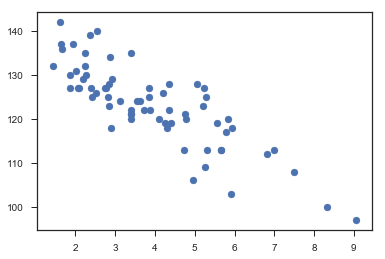

In [165]:
plt.scatter(V['TMAXpos'],V[0])

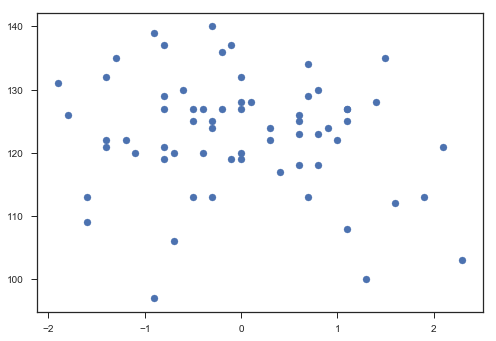

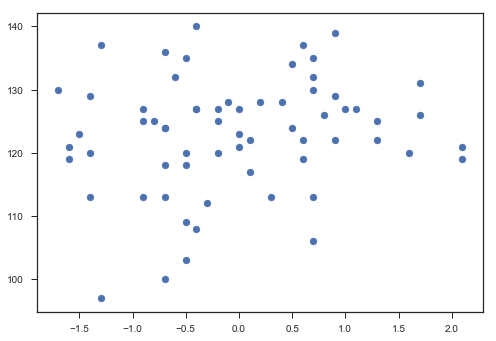

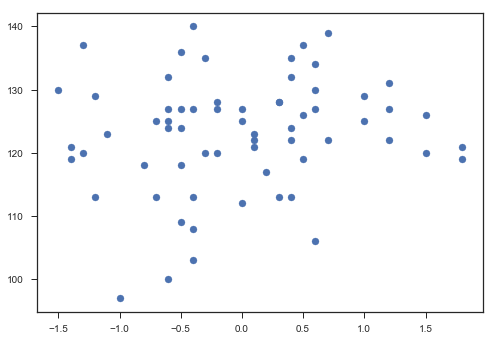

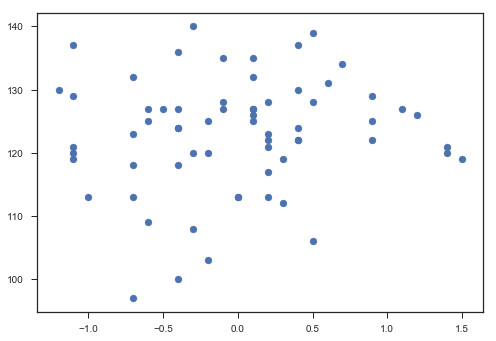

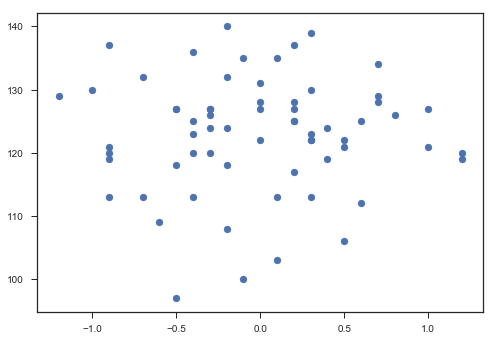

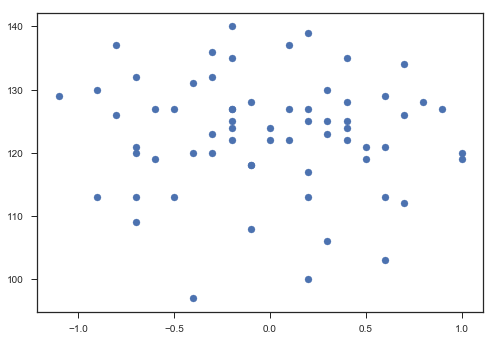

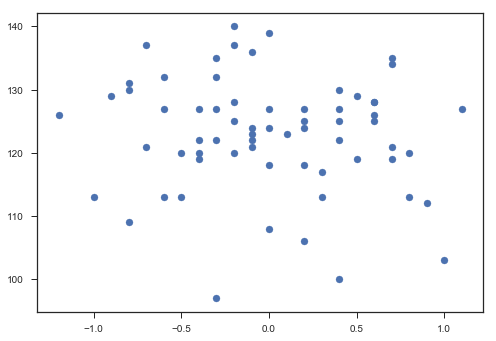

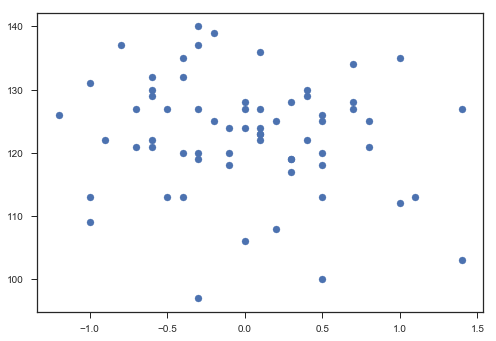

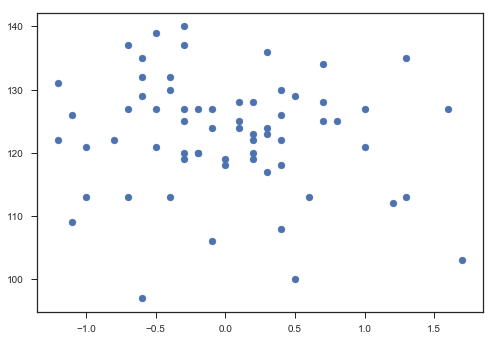

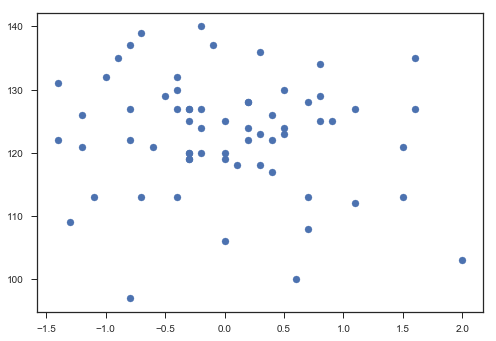

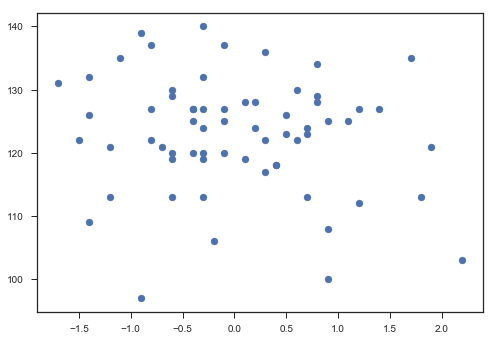

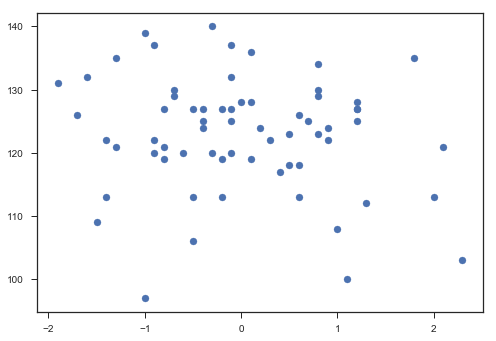

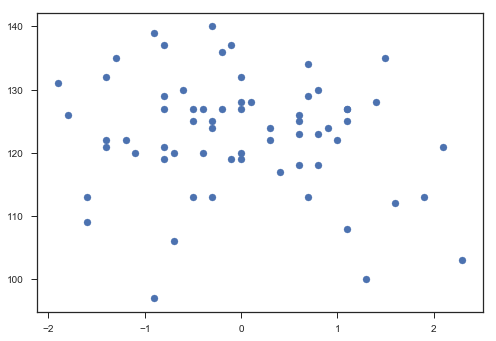

In [137]:
V.tail()
plt.scatter(V['ENSO'],V[0])

for k in ENSO.columns:
    Z = pd.DataFrame(index=Y.index)
    for y in ENSO.index:
        Z.ix[y+1,'ENSO'] = ENSO.ix[y,k]
    plt.figure()
    V = pd.concat([Y,Z,X],axis=1,join='outer')
    plt.scatter(V['ENSO'],V[0])



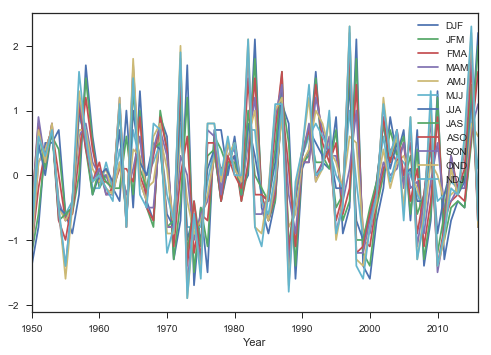

In [141]:
ENSO = pd.read_csv("ENSO.csv",index_col="Year")
ENSO.plot()

## Deprecated Cells

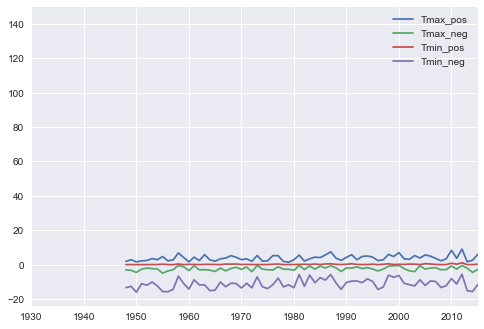

In [37]:
# Given two 'days of year', create a dataframe comprised of the mean value
# of the temperature regression features, indexed by year

def meanTemps(doy1,doy2):
    X = pd.DataFrame(index=Y.index)
    grouped = TEMP.groupby(TEMP.index.year)
    for y, T in grouped:
        T = T[T.index.dayofyear >= doy1]
        T = T[T.index.dayofyear <= doy2]
        for col in T.columns:
            X.ix[y,col] = T[col].mean()
    X.drop('TMAX',axis=1,inplace=True)
    X.drop('TMIN',axis=1,inplace=True)
    X = X.ix[Y.index]
    return X

X = meanTemps(50,105)


X.plot()
    
plt.legend(['Tmax_pos','Tmax_neg','Tmin_pos','Tmin_neg']);


plt.plot(X,Y)

In [69]:
grouped = TEMP.groupby(TEMP.index.year)
    for y, T in grouped:
        T = T[T.index.dayofyear >= doy1]
        T = T[T.index.dayofyear <= doy2]
        for col in T.columns:
            X.ix[y,col] = T[col].mean()
    X.drop('TMAX',axis=1,inplace=True)
    X.drop('TMIN',axis=1,inplace=True)
    X = X.ix[Y.index]
    return X

## Look for the Best Calendar Window for Temperatures

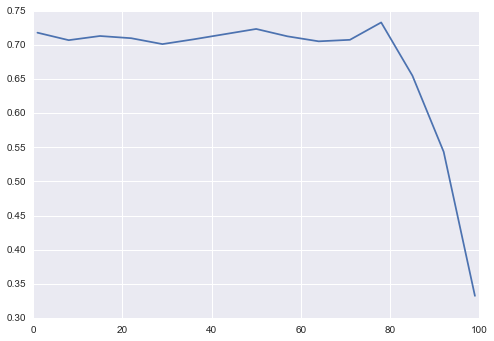

In [9]:
clf = ElasticNetCV(cv = 10, l1_ratio=0.5, n_alphas=1000)

def score(doy):
    X = meanTemps(doy,105)
    clf.fit(X,Y)
    return clf.score(X,Y)

doy = range(1,105,7)
plt.plot(doy,np.array([score(d) for d in doy]))